In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn import metrics
import random

In [2]:
data = pd.read_csv("encoded_data.csv")
data

,gender,ssc_percentage,ssc_board,hsc_percentage,hsc_board,degree_percentage,work_experience,emp_test_percentage,specialisation,mba_percent,status,hsc_subject_Arts,hsc_subject_Commerce,hsc_subject_Science,undergrad_degree_Comm&Mgmt,undergrad_degree_Others,undergrad_degree_Sci&Tech
0,1,67.00,0,91.00,0,58.00,0,55.0,0,58.80,1,0,1,0,0,0,1
1,1,79.33,1,78.33,0,77.48,1,86.5,1,66.28,1,0,0,1,0,0,1
2,1,65.00,1,68.00,1,64.00,0,75.0,1,57.80,1,1,0,0,1,0,0
3,1,56.00,1,52.00,1,52.00,0,66.0,0,59.43,0,0,0,1,0,0,1
4,1,85.80,1,73.60,1,73.30,0,96.8,1,55.50,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,1,80.60,0,82.00,0,77.60,0,91.0,1,74.49,1,0,1,0,1,0,0
211,1,58.00,0,60.00,0,72.00,0,74.0,1,53.62,1,0,0,1,0,0,1
212,1,67.00,0,67.00,0,73.00,1,59.0,1,69.72,1,0,1,0,1,0,0
213,0,74.00,0,66.00,0,58.00,0,70.0,0,60.23,1,0,1,0,1,0,0


### To properly assess model performance, we must split off a test set that is not used anywhere in model training or tuning.

In [3]:
# Separate features from outcome
X = data.drop(columns="status")
y = data["status"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
# Scale continuous features with StandardScaler
scaler = StandardScaler()

continuous_features = list(data.nunique()[data.nunique() > 2].index)
scaler.fit(X_train[continuous_features])
X_train[continuous_features] = scaler.transform(X_train[continuous_features])
X_test[continuous_features] = scaler.transform(X_test[continuous_features])

In [5]:
X = X_train
y = y_train

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [6]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=1)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_val)

In [7]:
cnf_matrix = metrics.confusion_matrix(y_val, y_pred)
cnf_matrix

array([[ 8,  2],
       [ 2, 23]])

Text(0.5, 427.9555555555555, 'Predicted label')

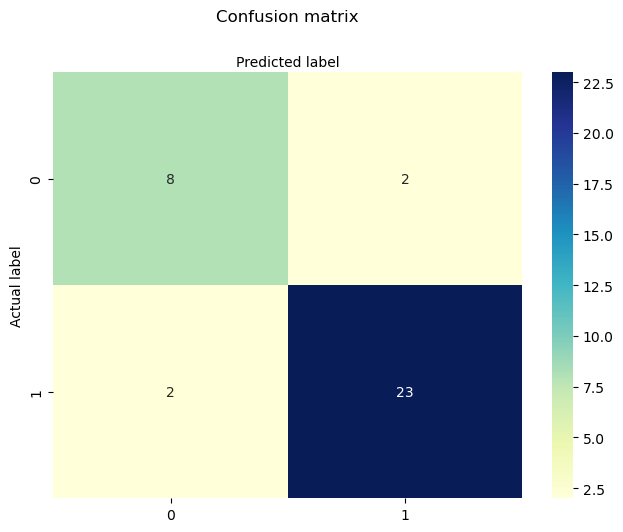

In [8]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Text(0.5,257.44,'Predicted label');

In [9]:
y_val.value_counts()

1    25
0    10
Name: status, dtype: int64

In [10]:
target_names = ["Not Placed", "Placed"]
print(classification_report(y_val, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Placed       0.80      0.80      0.80        10
      Placed       0.92      0.92      0.92        25

    accuracy                           0.89        35
   macro avg       0.86      0.86      0.86        35
weighted avg       0.89      0.89      0.89        35



# Recursive Feature Elimination

In [11]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
estimator = LogisticRegression()
selector = RFECV(estimator, step=1, cv=cv, scoring="f1")
selector = selector.fit(X, y)
print(selector.support_)

[False  True False False False False False False False False False False
 False False False False]


In [12]:
# Keep selected features

X_subset = X[list(X.columns[selector.support_])]

# Hyperparameters Tuning

In [13]:
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_subset, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.860458 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.860458 (0.074316) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.860458 (0.074316) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.860458 (0.074316) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.860458 (0.074316) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.860458 (0.074316) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.860458 (0.074316) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.852614 (0.076223) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.852614 (0.076223) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.860458 (0.074316) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.849020 (0.068785) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.849020 (0.068785) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.860458 (0.074316) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.698039 (0.015686) wit

# Final Model Testing

Text(0.5, 427.9555555555555, 'Predicted label')

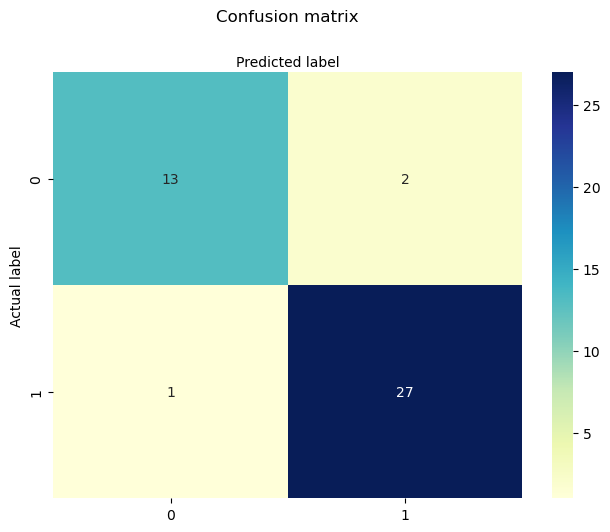

In [14]:
final_model = LogisticRegression(C=100, penalty='l2', solver='newton-cg')
# fit the model with data
final_model.fit(X, y)

y_pred = final_model.predict(X_test)

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [15]:
target_names = ["Not Placed", "Placed"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  Not Placed       0.93      0.87      0.90        15
      Placed       0.93      0.96      0.95        28

    accuracy                           0.93        43
   macro avg       0.93      0.92      0.92        43
weighted avg       0.93      0.93      0.93        43

